### Performance analysis of a Ka-radar system using GPM DPR products

#### Methodology

1. Build a database of Ka-band radar features and associated DPR surface precipitation. Features include $\int_{top}^{freezing}$ Z(Ka)$^{0.8}$ dr, $\int_{freezing}^{clutter}$ Z(Ka)$^{0.8}$ dr, max(Z(Ka)), near surface Z(Ka), SRT PIA(Ka), echo top, freezing level, and precipitation type.
2. The database is used to derive a statistical precipitation procedure that estimates, using a decision tree regressor, the surface precipitation as a function of the above mentioned features.
3.  A cross-validation methodology consisting of randomly splitting the database in two approximately equal parts is used.
4.  The correlation between the estimates and the reference precipitation in the validation dataset, the normalized Mean Absolute Error (MAE), i.e. estimate-reference/mean(reference) and the distributions of the absolute error are derived. The distribution of the estimated surface precipitation is also analyzed.  
5.  The above steps are shown in the code below.

#### Relevance to a Ka-band radar system different from the DPR Ka

1.  Results for stratiform precipitation are likely to extrapolate quite accurately as non-uniform beam filling and multiple scattering effects are minimal in stratiform rain. Moreover, increased sensitivity is going to enable finer details in observations and broader dynamic range in the SRT PIA. In addition, physical algorithms are likely to deliver better peformance than the statistical procedure use in this analysis.
2.  Results for convective precipitation are likely to extrapolate as well.  A system with higher sensitivity and higher resolution is going to observe systematically different distributions of reflectivities. However, such reflectivities can be converted into DPR Ka-like observations through convolution and multiple scattering calculations and the DPR-database described above can be used as "a priori" information in any Ka-band precipitation algorithm.

####  Error analysis

The analysis described above uses DPR precipitation estimates as a reference.  To investigate how the differences between Ka-band based precipitation retrievals and DPR dual-frequency precipitation retrievals relate to the accuracy of the Ka-band precipitation retrievals, a standard error analysis can be perform.  Specifically, the Ka-band and DPR precipitation estimates can be written as

$r_{Ka}=r_{true}+\epsilon_{ka}$ and 

$r_{DPR}=r_{true}+\epsilon_{DPR}$

Therefore, cov($r_{Ka}-r_{DPR}$)=cov($\epsilon_{Ka}-\epsilon_{DPR}$)=cov($\epsilon_{Ka}$)+cov($\epsilon_{DPR}$)-
2 cov($\epsilon_{Ka},\epsilon_{DPR}$)

The covariance of $r_{Ka}$ is cov($\epsilon_{Ka}$).  Therefore,  term cov($\epsilon_{DPR}$)-
2 cov($\epsilon_{Ka},\epsilon_{DPR}$) dictates whether the uncertainties in $r_{Ka}$ evaluated relative to $r_{DPR}$ are smaller or larger than the actual uncertainties.  This term is likely to be positive, because $\epsilon_{Ka}$ and $\epsilon_{DPR}$ are not likely to be well correlated, given that uncertainties in $r_{Ka}$ are mostly caused by ambiguities in the database (profiles with similar features but different rain rates), while uncertainties in $r_{DPR}$ are strongly influenced by DPR Ku-band observations, which are not used in the database.  Therefore, cov($r_{Ka}$) is likely to be smaller than cov($r_{Ka}-r_{DPR}$).

The estimated rain rates histograms are truncated at 100 mm/h, but, as apparent in the histograms, there are many estimates in the bin ending at 100mm/h.  Estimates as high as 250 mm/h are returned by the Decision Regression Tree. While such estimates may be highly erroneous (like those from any single frequency, single polarization radar for rain rate of such intensity), they are likely to be associated with very intense convective precipitation. From this perspective, it would be incorrect to assume that a Ka-band system cannot provide information on intensive convective rain.

[[1.         0.80277339]
 [0.80277339 1.        ]]
MAE= 30.93 %


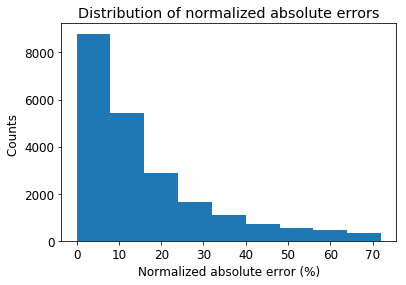

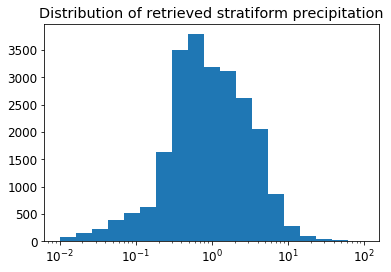

In [49]:
from netCDF4 import Dataset
from numpy import *
import matplotlib
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import matplotlib.colors as col
%matplotlib inline
fh=Dataset('featureDataBase.nc','r')
dBase=fh['featureDataBase'][:,:]
fh.close()
a=nonzero(dBase[:,-1]==1)  # select the stratiform profiles 
dBase_st=dBase[a[0],:]
Y=dBase_st[:,-2]  # this is the DPR (dual-frequency) surface precipitation
X=dBase_st[:,:-2] # these are the actual features
X[X<0]=0.
nx=Y.shape[0]
r=random.random(nx)  # generate random vector
a=nonzero(r>0.5)     # split the data in two (these are the indices of the entries used in training)
b=nonzero(r<0.5)     # these are indices of the entries used in validation
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor(random_state=0)   # define a Decision Tree Regresor
regressor.fit(X[a[0],:],Y[a[0]])                    # this is the training procedure
yb_st=regressor.predict(X[b[0],:]                   # prediction of surface precipitation based on features
print corrcoef(yb_st,Y[b[0]])                       # calculate the correlation coefficient
MAE=100*abs(yb_st-Y[b]).mean()/Y[b].mean()          # calculation of normalized Mean Absolute Error
                                                    # the following are diagnostic plots
print 'MAE=%6.2f %%'%MAE
matplotlib.rcParams.update({'font.size': 12})
plt.hist(abs(yb_st-Y[b])/Y[b].mean()*100,bins=arange(10)*8,density=False)
plt.xlabel('Normalized absolute error (%)')
plt.title('Distribution of normalized absolute errors')
plt.ylabel('Counts ')
plt.figure()
plt.hist(yb_st, bins=logspace(log10(0.01),log10(100.0), 20))
plt.title('Distribution of retrieved stratiform precipitation')
plt.gca().set_xscale("log")
plt.show()

[[1.         0.76774113]
 [0.76774113 1.        ]]
MAE= 46.06 %


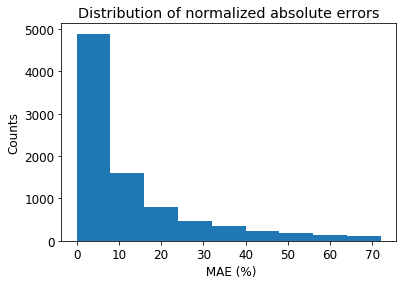

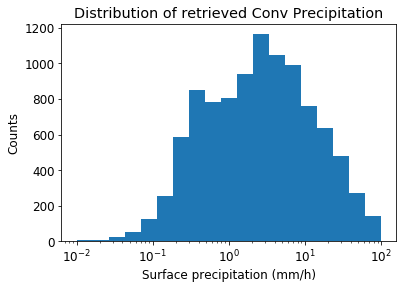

In [47]:
# same as before but for convective
a=nonzero(dBase[:,-1]==2)  # select the convective profiles 
dBase_cv=dBase[a[0],:]
Y=dBase_cv[:,-2]
X=dBase_cv[:,:-2]
X[X<0]=0.
nx=Y.shape[0]
r=random.random(nx)
a=nonzero(r>0.5)
b=nonzero(r<0.5)
regressor = DecisionTreeRegressor(random_state=0)
regressor.fit(X[a[0],:],Y[a[0]])
yb_cv=regressor.predict(X[b[0],:])
print corrcoef(yb_cv,Y[b[0]])
MAE=100*abs(yb_cv-Y[b]).mean()/Y[b].mean()
print 'MAE=%6.2f %%'%MAE
matplotlib.rcParams.update({'font.size': 12})
plt.hist(abs(yb_cv-Y[b])/Y[b].mean()*100,bins=arange(10)*8,density=False)
plt.xlabel(' MAE (%)')
plt.title('Distribution of normalized absolute errors')
plt.ylabel('Counts')
plt.figure()
plt.hist(yb_cv, bins=logspace(log10(0.01),log10(100.0), 20),density=False)
plt.xlabel('Surface precipitation (mm/h)')
plt.ylabel('Counts')
plt.title('Distribution of retrieved Conv Precipitation')
plt.gca().set_xscale("log")
plt.show()

Text(0.5,1,'Distribution of retrieved Conv+Strat precip')

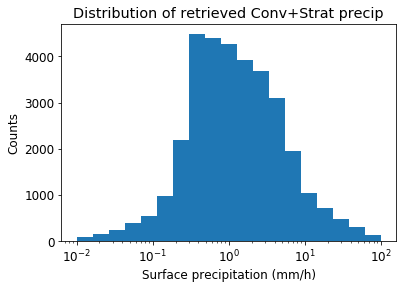

In [42]:
y=list(yb_st)
y.extend(yb_cv)
plt.hist(y, bins=logspace(log10(0.01),log10(100.0), 20),density=False)
plt.xlabel('Surface precipitation (mm/h)')
plt.ylabel('Counts')
plt.gca().set_xscale("log")
plt.title('Distribution of retrieved Conv+Strat precip')